In [25]:
import datacube
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog

import sys
sys.path.insert(1, '../../Tools/')
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import predict_xr
# from deafrica_tools.plotting import map_shapefile, rgb
# from deafrica_tools.classification import predict_xr, collect_training_data
# from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore")

In [26]:
create_local_dask_cluster(spare_mem='2Gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38375/status,
Dashboard: /proxy/38375/status,Workers: 1
Total threads: 12,Total memory: 13.10 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45747,Workers: 1
Dashboard: /proxy/38375/status,Total threads: 12
Started: Just now,Total memory: 13.10 GiB
Comm: tcp://127.0.0.1:40369,Total threads: 12
Dashboard: /proxy/40379/status,Memory: 13.10 GiB
Nanny: tcp://127.0.0.1:37637,


In [74]:
model_path = 'results/ml_model.joblib'
# lat_range = (15.70501873999827, 15.855673509998681)
# lon_range = (80.73028564453126, 80.89920043945314)
testing_locations = {
    'Margaret River': (22.40, 69.50)
}

buffer = 0.15

dask_chunks = {'x': 1000, 'y': 1000}

results = 'results/'

In [75]:
dc = datacube.Datacube(app='Classify_satellite_data')

In [76]:
model = load(model_path)

In [77]:
def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')

    #load ls8 geomedian
    
    ds = dc.load(product="s2a_sen2cor_granule",
                 **query)

    #calculate some band indices
    ds = calculate_indices(ds,
                           index=['NDVI', 'BUI', 'MNDWI'],
                           drop=False,
                           satellite_mission='s2')
    return ds

In [78]:
# Set up our inputs to collect_training_data
zonal_stats = None

# Set up the inputs for the ODC query
# time = ("2023")
time = ('2023-01-30', '2023-03-30')
resolution = (-30, 30)
output_crs = 'epsg:6933'

In [79]:
# Generate a new datacube query object
# lat_range = (15.80418332, 15.85828652)
# lon_range = (80.78694696, 81.02203692)
# lat_range = (15.70501873999827, 15.855673509998681)
# lon_range = (80.73028564453126, 80.89920043945314)
lat_range = (22.20376806142779, 22.554481733875678)
lon_range = (69.05921488827537, 70.05283866719262)
measurements =  ['blue','green','red','nir','swir_1','swir_2']
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs' : 'epsg:6933'
}

In [80]:
predictions = []

for key, value in testing_locations.items():

    print('Working on: ' + key)

    bounds = {'x': (value[1] - buffer, value[1] + buffer),
    'y': (value[0] + buffer, value[0] - buffer)}

    # Update datacube query

    query.update(bounds)

    # Load data and calculate features
    data = feature_layers(query).squeeze()

    # Predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True).compute()

    predictions.append(predicted)

Working on: Margaret River
predicting...
   probabilities...
   input features...


In [81]:
print(predictions)

[<xarray.Dataset>
Dimensions:        (x: 965, y: 1183)
Coordinates:
  * x              (x) float64 6.691e+06 6.691e+06 ... 6.72e+06 6.72e+06
  * y              (y) float64 2.805e+06 2.805e+06 ... 2.769e+06 2.769e+06
    spatial_ref    int32 6933
Data variables:
    Predictions    (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Probabilities  (y, x) float64 71.16 63.4 68.24 61.24 ... 76.0 73.06 70.27
    blue           (y, x) float64 1.747e+03 1.732e+03 ... 1.389e+03 1.527e+03
    green          (y, x) float64 1.953e+03 1.971e+03 ... 1.694e+03 1.882e+03
    red            (y, x) float64 1.526e+03 1.524e+03 ... 2.072e+03 2.332e+03
    nir            (y, x) float64 1.096e+03 1.081e+03 ... 2.811e+03 3.033e+03
    swir_1         (y, x) float64 1.036e+03 1.031e+03 ... 3.054e+03 3.393e+03
    swir_2         (y, x) float64 1.034e+03 1.035e+03 ... 2.591e+03 2.897e+03
    NDVI           (y, x) float64 -0.164 -0.1701 -0.1624 ... 0.1513 0.1307
    BUI            (y, x) float64 0.135

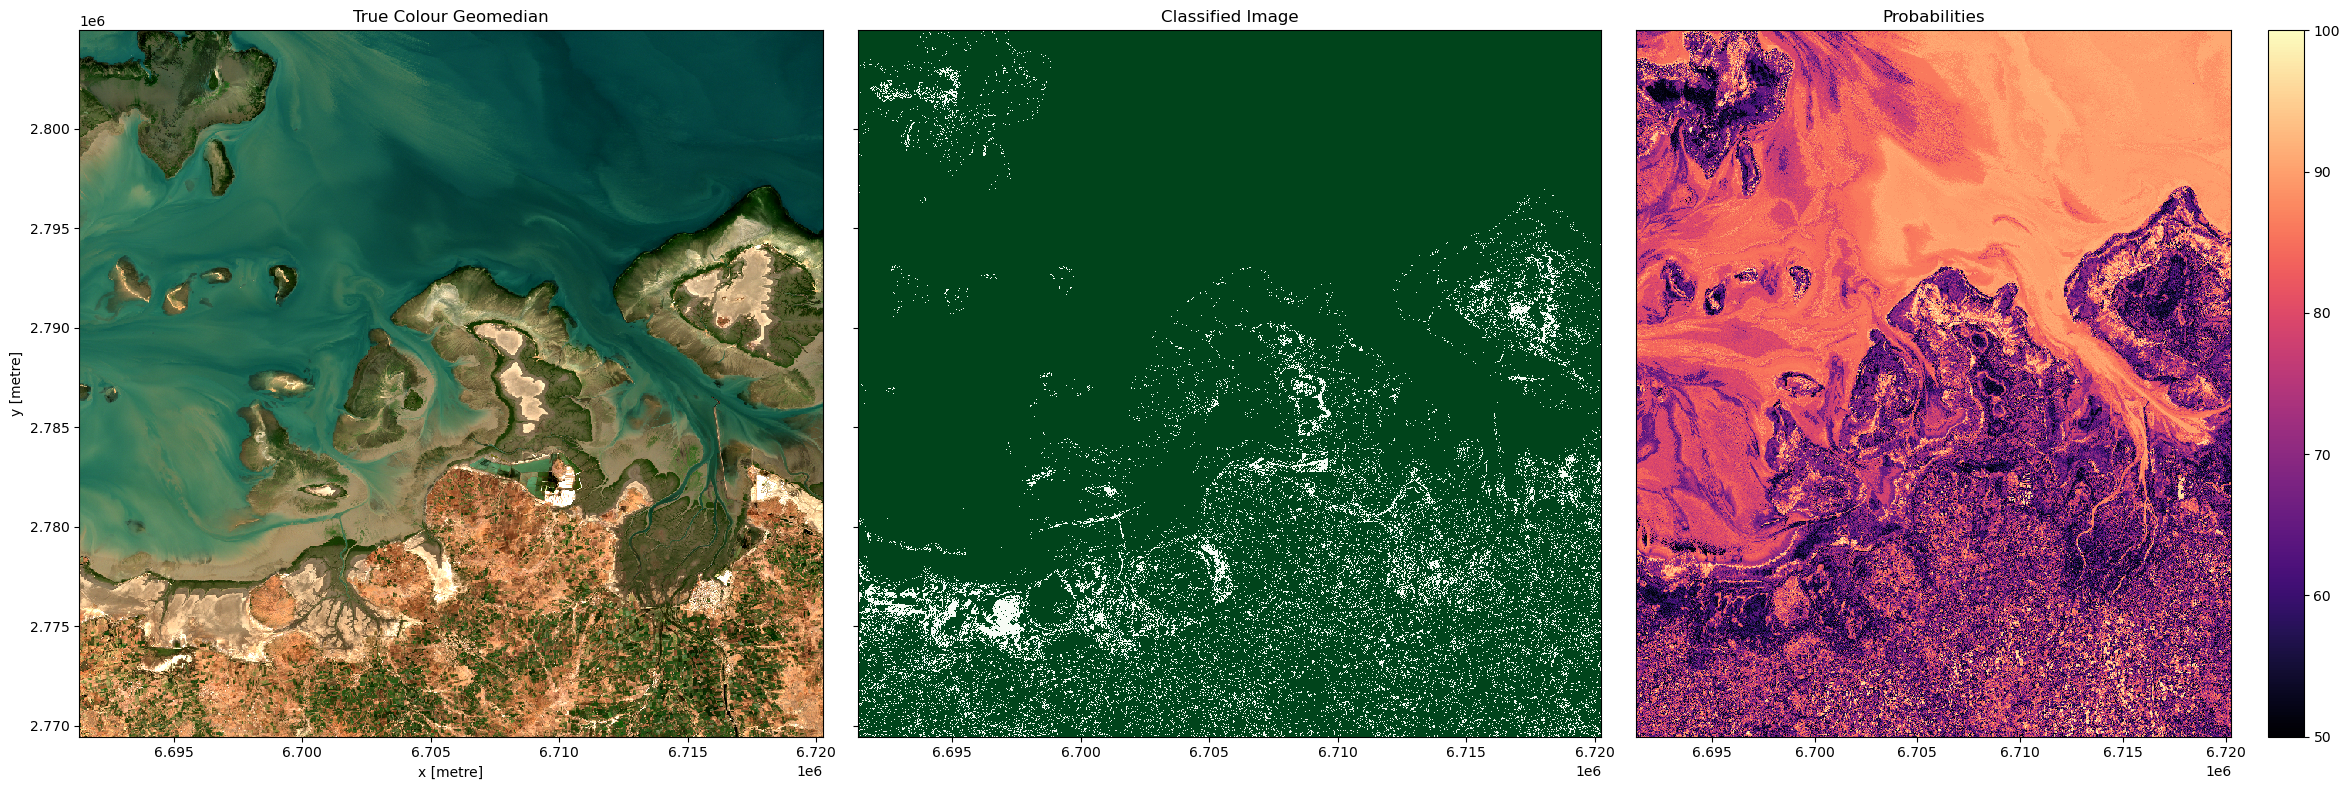

In [82]:
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Plot true colour image
    rgb(predictions[i],
        bands=['red', 'green', 'blue'],
        ax=axes[0],
        percentile_stretch=(0.01, 0.99))

    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[1],
                                    cmap='Greens',
                                    add_labels=False,
                                    add_colorbar=False)

    predictions[i].Probabilities.plot(ax=axes[2],
                                      cmap='magma',
                                      vmin=50,
                                      vmax=100,
                                      add_labels=False,
                                      add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('True Colour Geomedian')
    axes[1].set_title('Classified Image')
    axes[2].set_title('Probabilities')
    plt.tight_layout();

In [40]:
# Clear objects from memory
del data
del predictions
del predicted